<a href="https://colab.research.google.com/github/Shreyas-MS/ImageSuperresolution/blob/master/SR_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Dec  5 20:28:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from torchvision.utils import save_image
from torchvision.models import vgg19
import torchvision
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from skimage.metrics import structural_similarity

In [ ]:
!pip install kornia
from kornia.losses import ssim_loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551 kB 31.4 MB/s 


In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 30.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.5 MB/s 


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
LOAD_MODEL = True
SAVE_MODEL = True

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_PATH = "/content/drive/MyDrive/BTP/v2/"


LR = 1e-4
EPOCHS=40
BATCH_SIZE=16
if DEVICE == "cuda":
    BATCH_SIZE=24
NUM_WORKERS=4 if DEVICE=='cuda' else 2

SCALE = 4
if SCALE == 2:
    HR=128
else:
    HR=256



LOSS_METRIC = "mse"
LOSSES = {
    "mse": torch.nn.MSELoss(),
    "ssim":ssim_loss,
    }

DATASET = "outdoor_seg_images/images"

RES_BLOCKS = 20

SAVE = f"_{RES_BLOCKS}_{LOSS_METRIC}_{SCALE}"

GAN_LOSS = LOSSES[LOSS_METRIC]

CHANNELS=3

In [ ]:
print(f"images loaded from \t{BASE_PATH}{DATASET}")
print(f"models are saved in \t{BASE_PATH}model/{DATASET}/<discriminator/generator>{SAVE}")

images loaded from 	/content/drive/MyDrive/BTP/v2/outdoor_seg_images/images
models are saved in 	/content/drive/MyDrive/BTP/v2/model/outdoor_seg_images/images/<discriminator/generator>_20_mse_4


In [ ]:
class ImageDataset(Dataset):
    def __init__(self,img_paths):
        self.img_base_path = f"{BASE_PATH}{DATASET}"
        self.img_paths = img_paths
        self.hr_height = HR
        self.base_transforms = A.Compose(
            [
                A.PadIfNeeded(min_height=HR,min_width=HR),
                A.RandomCrop(width=HR, height=HR),
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
            ]
        )

        self.hr_transforms = A.Compose(
            [
                A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
                ToTensorV2(),
            ]
        )

        self.lr_transforms = A.Compose(
            [
                A.Resize(width=HR // SCALE, height=HR // SCALE, interpolation=Image.BICUBIC),
                A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
                ToTensorV2(),
            ]
        )

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,idx):
        img = np.array(Image.open(self.img_base_path+"/"+self.img_paths[idx]))
        img = self.base_transforms(image=img)["image"]
        hr = self.hr_transforms(image=img)["image"]
        lr = self.lr_transforms(image=img)["image"]

        return hr, lr


In [ ]:
img_base_path = f"{BASE_PATH}{DATASET}"

img_paths = [f for f in os.listdir(img_base_path) if os.path.isfile(os.path.join(img_base_path,f))]

train_paths,test_paths = train_test_split(img_paths,test_size=0.1,random_state=42, shuffle=True)



In [ ]:
print(len(train_paths))
print(train_paths[0])
print(len(test_paths))
print(test_paths[0])

8838
ADE_train_00012700.jpg
982
ADE_train_00004234.jpg


In [ ]:
dataset = ImageDataset(img_paths=train_paths)
dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,num_workers=8)

test_dataset = ImageDataset(img_paths=test_paths)
test_dataloader = DataLoader(test_dataset, num_workers=8)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for i,(hr,lr) in enumerate(dataloader):
    print(hr.shape)
    print(lr.shape)
    if i>1:
        break

torch.Size([24, 3, 256, 256])
torch.Size([24, 3, 64, 64])
torch.Size([24, 3, 256, 256])
torch.Size([24, 3, 64, 64])
torch.Size([24, 3, 256, 256])
torch.Size([24, 3, 64, 64])


In [ ]:
def print_img(img):
    plt.imshow(np.moveaxis(np.array(img),0,-1))

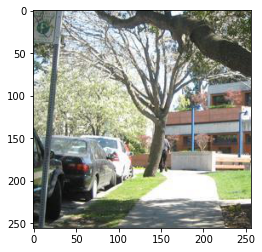

In [ ]:
test_img = dataset[0]

print_img(test_img[0])

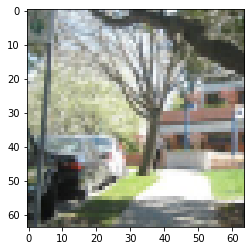

In [ ]:
print_img(test_img[1])

# Defining the model

In [ ]:
class ConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, gen_mode=True, act_fn = True, batch_norm=True, **kwargs,
    ):
        super().__init__()
        self.conv_nn = nn.Conv2d(in_ch,out_ch,**kwargs, bias=not batch_norm)
        self.bn = nn.Identity()
        if batch_norm:
            self.bn = nn.BatchNorm2d(out_ch)
        self.activ = nn.LeakyReLU(0.2, inplace=True)
        if gen_mode:# generator
            self.activ = nn.PReLU(num_parameters=out_ch)
        self.act_fn = act_fn


    def forward(self, x):
        x = self.conv_nn(x)
        x = self.bn(x)
        if self.act_fn:
            return self.activ(x)
        return x

class UpBlock(nn.Module):
    # try to upsample by 2x here

    def __init__(self, in_ch, k):
        super().__init__()
        self.activ_fn = nn.PReLU(num_parameters=in_ch)
        self.conv_nn = nn.Conv2d(in_ch, in_ch*(k**2),kernel_size=3, stride=1,padding=1)
        self.pix_shuffle = nn.PixelShuffle(k) # flatten dimensions from in*4,h,w to in, 2h,2w

    def forward(self, x):
        x = self.conv_nn(x)
        x = self.pix_shuffle(x)
        return self.activ_fn(x)

class ResBlock(nn.Module):
    # k3n64s1 conv, Batchnorm and relu/prelu

    def __init__(self, in_ch):
        super().__init__()
        self.conv_block1 = ConvBlock(in_ch,in_ch, kernel_size = 3, stride=1,padding=1)
        self.conv_block2 = ConvBlock(in_ch,in_ch, kernel_size = 3, stride=1,padding=1,act_fn=False)

    def forward(self, x):
        out = self.conv_block2(self.conv_block1(x))
        return out + x


class Generator(nn.Module):
    def __init__(self, in_ch=CHANNELS, blocks = 20, num_ch = 64) -> None:
        super().__init__()
        # ceil((in_ch - kernel +1 + padding*2)/(stride)) is out_ch
        self.conv_block1 = ConvBlock(in_ch, num_ch,kernel_size = 9, stride=1,padding=4, batch_norm=False)
        self.res_layers = [ResBlock(num_ch) for x in range(blocks)]
        self.resnet = nn.Sequential(*self.res_layers)
        self.conv_block2 = ConvBlock(num_ch,num_ch,kernel_size=3, stride=1,padding=1, act_fn=False)
        self.upscale = UpBlock(num_ch,k=SCALE) # scale up by SCALE
        self.conv3 = nn.Conv2d(num_ch,in_ch, kernel_size=9,stride=1,padding=4)

    def forward(self,x):
        cvb1_out = self.conv_block1(x)
        x = self.resnet(cvb1_out)
        x = self.conv_block2(x) + cvb1_out
        x = self.upscale(x)
        return torch.tanh(self.conv3(x))

class Discriminator(nn.Module):
    def __init__(self, in_ch=CHANNELS, features=[64, 64, 128, 128, 256, 256, 512, 512] ):
        super().__init__()
        blocks = []
        for idx, n_feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_ch,
                    n_feature,
                    gen_mode=False,
                    batch_norm=False if idx == 0 else True,
                    act_fn=True,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                )
            )
            in_ch = n_feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((12, 12)), # ex input is 96, we divide by two, 4 times
            nn.Flatten(),
            nn.Linear(512*12*12, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)


In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator.eval()

Generator(
  (conv_block1): ConvBlock(
    (conv_nn): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (bn): Identity()
    (activ): PReLU(num_parameters=64)
  )
  (resnet): Sequential(
    (0): ResBlock(
      (conv_block1): ConvBlock(
        (conv_nn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): PReLU(num_parameters=64)
      )
      (conv_block2): ConvBlock(
        (conv_nn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): PReLU(num_parameters=64)
      )
    )
    (1): ResBlock(
      (conv_block1): ConvBlock(
        (conv_nn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
discriminator.eval()

Discriminator(
  (blocks): Sequential(
    (0): ConvBlock(
      (conv_nn): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): Identity()
      (activ): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): ConvBlock(
      (conv_nn): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): ConvBlock(
      (conv_nn): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): ConvBlock(
      (conv_nn): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): 

In [ ]:
inp_lr = dataset[0][1].reshape([1,3,HR//SCALE,HR//SCALE])
# nn.Conv2d(in_channels=3,out_channels=64,kernel_size=9,stride=1,padding=4)(x)
fake_img = generator(inp_lr)

torch.Size([1, 3, 256, 256])

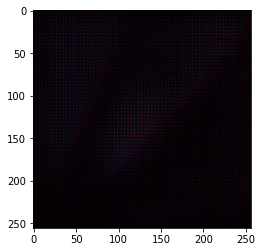

In [ ]:
print_img(fake_img.detach()[0])
fake_img.shape

In [ ]:
print(discriminator(fake_img))

tensor([[0.0143]], grad_fn=<AddmmBackward0>)


# Training Loop

In [ ]:
print(f"{BASE_PATH}models/{DATASET}")

/content/drive/MyDrive/BTP/v2/models/outdoor_seg_images/images


In [ ]:
ep=-1

In [ ]:
# check last saved model:

model_bp = f"{BASE_PATH}models/{DATASET}"

disc_bp = f"{model_bp}/discriminator{SAVE}"
disc_models = [f for f in os.listdir(disc_bp) if os.path.isfile(os.path.join(disc_bp,f))]
gen_bp = f"{model_bp}/generator{SAVE}"
gen_models = [f for f in os.listdir(gen_bp) if os.path.isfile(os.path.join(gen_bp,f))]
ep = -1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if len(disc_models) > 0:
    discriminator.load_state_dict(torch.load(f"{disc_bp}/{disc_models[-1]}", map_location = device))
if len(gen_models) > 0:
    generator.load_state_dict(torch.load(f"{gen_bp}/{gen_models[-1]}", map_location=device))
    ep = int(gen_models[-1].split(".")[0])
print(f"start from epoch = {ep+1}")

start from epoch = 40


In [ ]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR)
G_loss = torch.nn.MSELoss()
C_loss = GAN_LOSS

lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg')

cuda = True if torch.cuda.is_available() else False

if cuda:
    generator.cuda()
    discriminator.cuda()
    # optimizer_G.cuda()
    # optimizer_D.cuda()
    G_loss.cuda()
    if LOSS_METRIC == "mse":
        C_loss.cuda()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
train_gen_losses, train_disc_losses, train_counter = [], [], []

for epoch in range(ep+1, EPOCHS):
    gen_loss, disc_loss = 0,0
    tqdm_bar = tqdm(
        dataloader,
        desc=f'Training Epoch {epoch} ',
        total=int(len(dataloader))
        )

    for batch_idx, imgs in enumerate(tqdm_bar):
        hr,lr = imgs
        if torch.cuda.is_available():
            hr = hr.to("cuda")
            lr = lr.to("cuda")
        generator.train()
        discriminator.train()

        optimizer_G.zero_grad()
        optimizer_D.zero_grad()

        fake_hr = generator(lr) # fake generated img
        real_pred = discriminator(hr) # pass real img thru disc
        fake_pred = discriminator(fake_hr) # pass fake hr into disc

        # get discriminator loss first
        real_targ = torch.ones_like(real_pred)
        real_img_loss = G_loss(real_targ,real_pred)

        fake_targ = torch.zeros_like(fake_pred)
        fake_img_loss = G_loss(fake_targ, fake_pred.detach())

        total_disc_loss = real_img_loss + fake_img_loss

        total_disc_loss.backward()
        optimizer_D.step()
        train_disc_losses.append(total_disc_loss.item())

        # calculate generator loss
        gen_loss = fake_img_loss*1e-3
        if LOSS_METRIC =="mse":
            gen_loss += C_loss(hr,fake_hr)
        elif LOSS_METRIC == "ssim":
            gen_loss+=C_loss(hr,fake_hr,11)

        train_gen_losses.append(gen_loss.item())

        gen_loss.backward()
        optimizer_G.step()

        if batch_idx%10==0:
            print(f"\ngen_loss:{gen_loss}\t disc_loss:{total_disc_loss}")

    torch.save(generator.state_dict(),  f"{model_bp}/generator{SAVE}/{epoch}.pth")

    torch.save(discriminator.state_dict(),  f"{model_bp}/discriminator{SAVE}/{epoch}.pth")
    ep = epoch

# TESTING LOOP

In [ ]:

batch_idx=0
test_tqdm_bar = tqdm(
    test_dataloader,
    desc='Testing',
    total=int(len(test_dataloader))
    )
y_preds = []
y_true = []
ssim_score = []
lpip_score = []
for batch_idx, imgs in enumerate(test_tqdm_bar):
    hr,lr = imgs
    if torch.cuda.is_available():
        hr = hr.to("cuda")
        lr = lr.to("cuda")
    generator.eval()
    discriminator.eval()

    fake_hr = generator(lr).resize(HR,HR,3) # fake generated img

    # store results.
    fhr_eval = fake_hr.detach().cpu()
    hr_eval = hr.detach().cpu()

    y_preds.append(fhr_eval.view(3,HR,HR))
    y_true.append(hr_eval.view(3,HR,HR))
    lpip_score.append(lpips(fhr_eval.view(1,3,HR,HR), hr_eval.view(1,3,HR,HR)).detach().numpy())
    ssim_score_item = structural_similarity(fhr_eval.view(HR,HR,3).numpy(), hr_eval.view(HR,HR,3).numpy(), multichannel=True,win_size=11)
    ssim_score.append(ssim_score_item)
    del ssim_score_item, fhr_eval, hr_eval

Testing:   0%|          | 0/982 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
Testing: 100%|██████████| 982/982 [21:34<00:00,  1.32s/it]


In [ ]:
ssim_score = np.array(ssim_score)

In [ ]:
np.mean(ssim_score)

0.870854188254701

## MEAN SSIM SCORE
* 4x trained with SSIM loss: 0.8719062082450828
* 2x trained with SSIM loss: 0.9408866435250766

In [ ]:
print(y_preds[0].shape)
print(y_true[0].shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [ ]:
(np.mean(np.array((lpip_score))) + 1)/2

0.6540483236312866

Paper implementation with mse loss for 4x:

    lpip: 0.663533627986908
    ssim: 0.8640918060280227

Our implementation with ssim loss for 4x:

    lpip: 0.6596860587596893
    ssim: 0.8719062082450828


Paper implementation with ssim loss for 2x:

    lpip: 0.6540483236312866
    ssim: 0.870854188254701




Our implementation with ssim loss for 2x:

    lpip: 0.5712261945009232
    ssim: 0.9417628798924162




# RUN THE NEXT 4 CELLS FOR INFERENCE/TESTING

In [ ]:
inp = dataset[np.random.randint(0,len(dataset))]
inp_lr = inp[1].reshape([1,CHANNELS,HR//SCALE,HR//SCALE])
if DEVICE == 'cuda':
    inp_lr = inp_lr.cuda()
fake_img = generator(inp_lr)

LR image


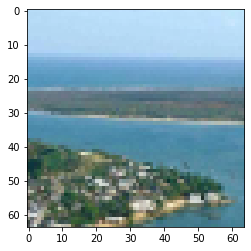

In [ ]:
print("LR image")
print_img(inp_lr[0].cpu())

HR original


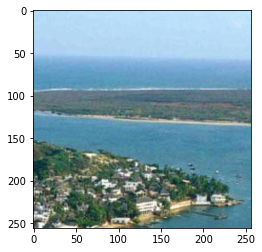

In [ ]:
print("HR original")
inp_hr = inp[0].reshape([CHANNELS,HR,HR])
print_img(inp_hr)

fake image


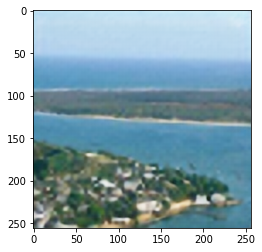

In [ ]:
print("fake image")
print_img(fake_img.reshape(CHANNELS,HR,HR).cpu().detach())

In [ ]:
lpip_score = lpips(y_pred,y_tru)

NameError: ignored

In [ ]:
del lpip_score

In [ ]:
torch.save(discriminator.state_dict(), f"{BASE_PATH}/models/discriminator/{epoch}.pth")